In [15]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
class RNN(nn.Module):
    def __init__(self, hidden_size, in_size=1):
        super().__init__()
        self.x2h = nn.Linear(in_size, hidden_size) # input to hidden
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False) # hidden to hidden
        self.h = None # hidden state
    
    def forward(self, x):
        if self.h is None:
            self.h = torch.tanh(self.x2h(x))
        else:
            self.h = torch.tanh(self.x2h(x) + self.h2h(self.h))
        return self.h
    
    def reset_state(self):
        self.h = None

In [3]:
class simpleRNN(nn.Module):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = RNN(hidden_size)
        self.fc = nn.Linear(hidden_size, out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y

In [4]:
seq_data = torch.tensor(np.cos(np.linspace(0, 4*np.pi, 1000))).view(-1, 1, 1).float()
xs = seq_data[:-1]
ts = seq_data[1:]

loss, cnt = 0, 0
bptt = 30
num_epochs = 1000

model = simpleRNN(100, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_hist = []

for epoch in range(num_epochs):
    loss_mean = 0
    for x, t in zip(xs, ts):
        x = x.view(1, 1)
        t = t.view(1, 1)
        y = model(x)
        loss += criterion(y, t)
        loss_mean += loss.item()
        cnt += 1
        if cnt == bptt or epoch == num_epochs-1:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.reset_state()
            loss, cnt = 0, 0
    loss_hist.append(loss_mean / len(xs))

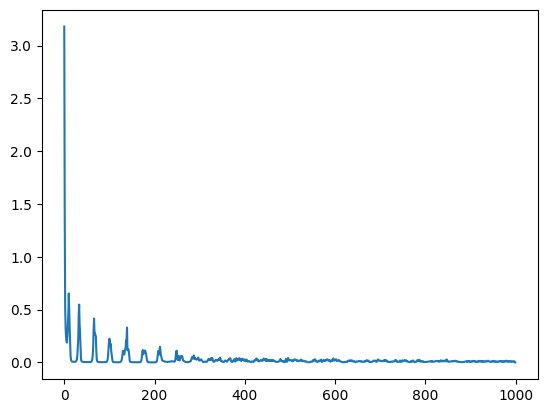

In [5]:
import matplotlib.pyplot as plt

plt.plot(loss_hist)
plt.show()

In [6]:
pred_data = seq_data[:-1]
pred = []

for x in pred_data:
    x = x.view(1, 1)
    y = model(x)
    pred.append(y.item())

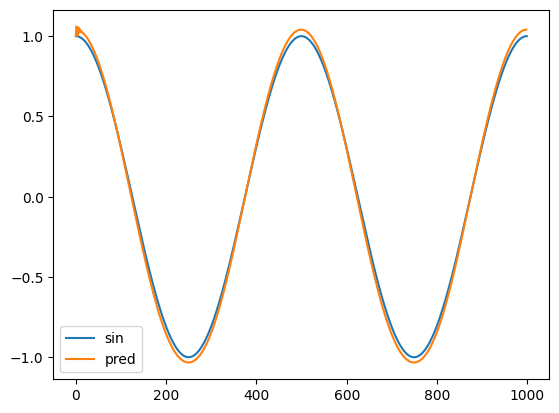

In [7]:
seq_data = seq_data.view(-1).numpy()
plt.plot(seq_data, label='sin')
plt.plot(pred, label='pred')
plt.legend()
plt.show()

## LSTM

In [188]:
class simple_LSTM(nn.Module):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.lstm = nn.LSTM(1, hidden_size)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h, _ = self.lstm(x)
        y = self.fc(h)
        self.h = h.detach()
        return y

In [183]:
bptt = 20
seq_data = torch.tensor(np.cos(np.linspace(0, 4*np.pi, 1000)))
seq_data = seq_data.view(-1, 1, 1).float()
seq_data.shape

torch.Size([1000, 1, 1])

In [152]:
xs = seq_data[:-1]
ts = seq_data[1:]

loss, cnt = 0, 0
num_epochs = 100
bptt = 10

model = simple_LSTM(100, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_hist = []

for epoch in range(num_epochs):
    loss_mean = 0
    for i in range(0, len(xs), bptt):
        x = xs[i:i+bptt]
        t = ts[i:i+bptt]
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_mean += loss.item()
    loss_hist.append(loss_mean / (len(xs) / bptt))


In [ ]:
model.

In [154]:
y = pred.view(-1).detach().numpy()

In [155]:
len(pred)

999

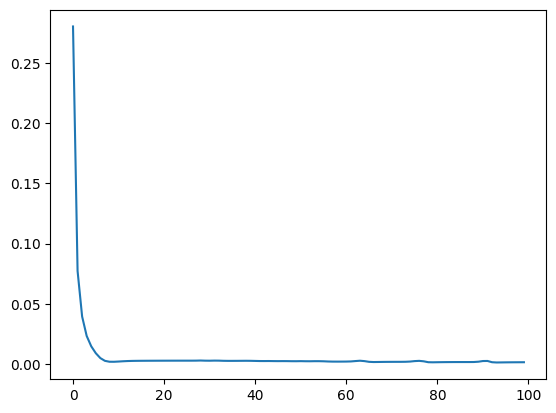

In [156]:
plt.plot(loss_hist)
plt.show()

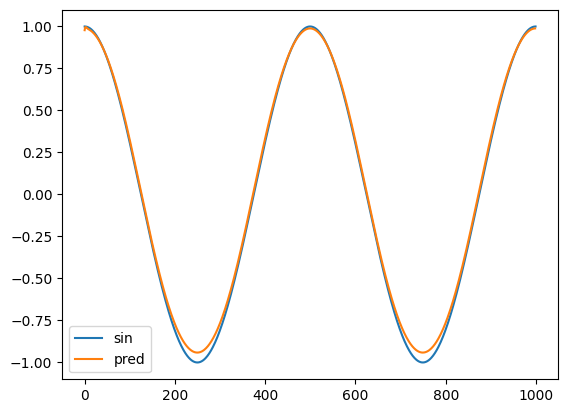

In [157]:
plt.plot(seq_data.view(-1).numpy(), label='sin')
plt.plot(y, label='pred')
plt.legend()
plt.show()

In [205]:
class LSTM(nn.Module):
    """LSTM"""
    def __init__(self, z_size=32, a_size=3, hidden_size=256):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(z_size + a_size, hidden_size)
    
    def forward(self, z, a, h, c):
        input = torch.cat((z, a), dim=2) # (seq_len, batch, input_size)
        out, (h, c) = self.lstm(input, (h, c))
        return out, h, c


In [206]:
ls = LSTM()
z = torch.randn(10, 5, 32) # (seq_len, batch, z_size)
a = torch.randn(10, 5, 3)
h = torch.randn(1, 5, 256)
c = torch.randn(1, 5, 256)
out, h, c = ls(z, a, h, c)
out.shape, h.shape, c.shape

(torch.Size([10, 5, 256]), torch.Size([1, 5, 256]), torch.Size([1, 5, 256]))

In [207]:
class MDN(nn.Module):
    """Mixtures Density Network"""
    def __init__(self, z_size=32, hidden_size=256,num_mixtures=5, use_reward=False, use_Done=False):
        super().__init__()
        self.z_size = z_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.use_reward = use_reward
        self.use_Done = use_Done

        if use_reward and use_Done:
            self.output_size = 3 * num_mixtures * z_size + 2
        elif use_reward or use_Done:
            self.output_size = 3 * num_mixtures * z_size + 1
        else:
            self.output_size = 3 * num_mixtures * z_size
        
        self.fc = nn.Linear(hidden_size, self.output_size)
    
    def forward(self, x):
        output = self.fc(x) 
        # return output
        if self.use_reward and self.use_Done:
            pi, mu, logsigma, reward, done = self.get_mixture(output)
            return pi, mu, logsigma, reward, done
        elif self.use_reward or self.use_Done:
            pi, mu, logsigma, reward_done = self.get_mixture(output)
            return pi, mu, logsigma, reward_done
        else:
            pi, mu, logsigma = self.get_mixture(output)
            return pi, mu, logsigma
    
    def get_mixture(self, output):
        params_dim = self.num_mixtures * self.z_size
        pi = output[:, :, :params_dim]
        mu = output[:, :, params_dim:2*params_dim]
        logsigma = output[:, :, 2*params_dim:3*params_dim]

        if self.use_reward and self.use_Done:
            reward = output[:, :, 3*params_dim]
            done = output[:, :, 3*params_dim+1]
            return pi, mu, logsigma, reward, done
        elif self.use_reward or self.use_Done:
            reward_done = output[:, :, 3*params_dim]
            return pi, mu, logsigma, reward_done
        else:
            return pi, mu, logsigma

In [208]:
mdn = MDN()
z = torch.randn(10, 5, 32) # (seq_len, batch, z_size)
a = torch.randn(10, 5, 3)
h = torch.randn(1, 5, 256)
c = torch.randn(1, 5, 256)
out, h, c = ls(z, a, h, c)
pi, mu, logsigma = mdn(out)
pi.shape, mu.shape, logsigma.shape

(torch.Size([10, 5, 160]), torch.Size([10, 5, 160]), torch.Size([10, 5, 160]))

In [209]:
class MDNRNN(nn.Module):
    """MDN-RNN"""
    def __init__(self, z_size=32, a_size=3, hidden_size=256, num_mixtures=5, use_reward=False, use_Done=False):
        super().__init__()
        self.z_size = z_size
        self.a_size = a_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.use_reward = use_reward
        self.use_Done = use_Done

        self.lstm = LSTM(z_size, a_size, hidden_size)
        self.mdn = MDN(z_size, hidden_size, num_mixtures, use_reward, use_Done)
    
    def forward(self, z, a, hidden, cell):
        out, h, c = self.lstm(z, a, hidden, cell)
        pi, mu, logsigma = self.mdn(out)
        return pi, mu, logsigma

In [261]:
mdnrnn = MDNRNN()
z = torch.randn(10, 5, 32) # (seq_len, batch, z_size)
a = torch.randn(10, 5, 3)
h = torch.randn(1, 5, 256)
c = torch.randn(1, 5, 256)
pi, mu, logsigma = mdnrnn(z, a, h, c)
pi.shape, mu.shape, logsigma.shape

(torch.Size([10, 5, 160]), torch.Size([10, 5, 160]), torch.Size([10, 5, 160]))

In [279]:
"""
input:
    pi: (seq_len, batch, num_mixtures * z_size)
    mu: (seq_len, batch, num_mixtures * z_size)
    logsigma: (seq_len, batch, num_mixtures * z_size)
    y_true: (seq_len, batch, z_size)
output:
    loss: mean((seq_len, batch, 1))
"""
import math

def loss_func(seq_len, batch_size, z_size, num_mixtures, pi, mu, logsigma, y_true):
    y_true = y_true.view(seq_len, batch_size, z_size, 1) # (seq_len, batch, 1, z_size)

    pi = pi.view(seq_len, batch_size, z_size, num_mixtures) # (seq_len, batch, z_size, num_mixtures)
    mu = mu.view(seq_len, batch_size, z_size, num_mixtures) # (seq_len, batch, z_size, num_mixtures)
    logsigma = logsigma.view(seq_len, batch_size, z_size, num_mixtures) # (seq_len, batch, z_size, num_mixtures)

    torch.max(pi, dim=3)[0].shape
    pi = pi - torch.max(pi, dim=3)[0].view(seq_len, batch_size, z_size, 1) # (seq_len, batch, z_size, num_mixtures)
    logpi = nn.LogSoftmax(dim=3)(pi) # (seq_len, batch, z_size, num_mixtures)
    loggausian = -0.5 * (2*logsigma + (y_true - mu)**2 / (torch.exp(logsigma))**2) # (seq_len, batch, z_size, num_mixtures)

    loss = logpi + loggausian # (seq_len, batch, z_size, num_mixtures)
    loss = torch.sum(loss, dim=3) # (seq_len, batch, num_mixtures)
    loss = -loss # (seq_len, batch, num_mixtures)
    return torch.mean(loss)

## MDN-RNN Train

In [294]:
from models.MDN_RNN import MDNRNN, loss_func
import rollout
import os

In [295]:
def make_dataset_rnn(seq_len, batch_size, idx, use_reward=False, use_Done=False):
    cr = rollout.CarRacing_rollouts()
    Z = np.zeros((batch_size, seq_len, 32)) # (batch, seq, z_dim)
    A = np.zeros((batch_size, seq_len, 3)) # (batch, seq, a_dim)
    Reward = np.zeros((batch_size, seq_len, 1)) # (batch, seq, dim)
    Done = np.zeros((batch_size, seq_len, 1)) # (batch, seq, dim)
    for i, j in enumerate(idx):
        z, _, _, action, reward, _ = cr.load_rollout_z(j)
        Z[i] = z
        A[i] = action
        if use_reward:
            Reward[i] = reward
        if use_Done:
            Done[i] = done
    
    return Z, A, Reward, Done

In [296]:
dataset_idx = np.array([id for id in range(9000)]).astype(int)
np.random.shuffle(dataset_idx)

Z, A, _, _ = make_dataset_rnn(300, 5, dataset_idx[:5])
Z.shape, A.shape

((5, 300, 32), (5, 300, 3))

In [298]:
seq_len = 300
batch_size = 10
n = 10000
num_epoch = 10
bptt = 20

file_list = os.listdir('./data_z/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mdnrnn = MDNRNN().to(device)
optimizer = optim.Adam(mdnrnn.parameters(), lr=1e-3)
checkpoint_epoch = -1

TypeError: LSTM.__init__() takes from 1 to 4 positional arguments but 5 were given

In [ ]:
if (i+1) % 10 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, 9000 // batch_size, loss.item()))
                print("Use Memory: {:.2f} MB".format(torch.cuda.memory_allocated() / 1024 / 1024))

In [ ]:
if checkpoint_epoch + 1 == num_epochs:
    print('already trained')
else:
    for epoch in range(checkpoint_epoch+1, num_epochs):
        dataset_idx = np.array([id for id in range(9000)]).astype(int)
        np.random.shuffle(dataset_idx)
        loss_mean = 0
        for i in range(9000 // batch_size):
            Z, A, _, _ = make_dataset_rnn(seq_len, batch_size, dataset_idx[i*batch_size:(i+1)*batch_size])
            Z = torch.tensor(Z).float().to(device).permute(1, 0, 2) # (seq_len, batch, z_size)
            A = torch.tensor(A).float().to(device).permute(1, 0, 2) # (seq_len, batch, a_size)
            H = torch.zeros(1, batch_size, 256).float().to(device)
            C = torch.zeros(1, batch_size, 256).float().to(device)

            in_Z = Z[:-1] # (seq_len-1, batch, z_size)
            out_Z = Z[1:] # (seq_len-1, batch, z_size)
            A = A[:-1] # (seq_len-1, batch, a_size)

            mdnrnn.train()
            optimizer.zero_grad()

            for i in range(0, seq_len-1, bptt):
                in_z = in_Z[i:i+bptt] # (bptt, batch, z_size)
                out_z = out_Z[i:i+bptt] # (bptt, batch, z_size)
                a = A[i:i+bptt] # (bptt, batch, a_size)
                pi, mu, logsigma, H, C = mdnrnn(a, in_z, H, C)
                loss = loss_func(out_z, pi, mu, logsigma)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            loss_mean += loss.item()

            # GPU memory: remove data
            del Z, A, H, C, in_Z, out_Z, a, pi, mu, logsigma
        
        print("save model: epoch {}".format(epoch + 1))
        torch.save({
            'epoch': epoch,
            'model_state_dict': mdnrnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'mdnrnn2.pth')
        
        del loss

        mdnrnn.eval()
        print("test: epoch {}".format(epoch + 1))
        with torch.no_grad():
            test_idx = np.array([i for i in range(9000, 10000)]).astype(int)
            loss_mean = 0
            for i in range(1000 // batch_size):
                Z = torch.tensor(Z).float().to(device).permute(1, 0, 2) # (seq_len, batch, z_size)
                A = torch.tensor(A).float().to(device).permute(1, 0, 2) # (seq_len, batch, a_size)
                H = torch.zeros(1, batch_size, 256).float().to(device)
                C = torch.zeros(1, batch_size, 256).float().to(device)

                in_Z = Z[:-1]
                out_Z = Z[1:]
                A = A[:-1]

                for i in range(0, seq_len-1, bptt):
                    in_z = in_Z[i:i+bptt]
                    out_z = out_Z[i:i+bptt]
                    a = A[i:i+bptt]
                    pi, mu, logsigma, H, C = mdnrnn(a, in_z, H, C)
                    loss = loss_func(out_z, pi, mu, logsigma)
                    loss_mean += loss.item()
                loss_mean /= (seq_len-1) // bptt

                if (i+1) % 10 == 0:
                    print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, 1000 // batch_size, loss_mean))
                    print("Use Memory: {:.2f} MB".format(torch.cuda.memory_allocated() / 1024 / 1024))

                # GPU memory: remove data
                del Z, A, H, C, in_Z, out_Z, a, pi, mu, logsigma